In [258]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

from collections import defaultdict
import math
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd

from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import _get_term_features, _get_last_n_action_features, \
            _get_action_features, _get_repeatition_features, _get_balance_features, documents2feature_vectors

In [2]:
# add spearman correlation
# change name of the features: graph_feature_..., linguistic_feature_...

# Experiment on the smaller set (4-6-bad_convs)

In [3]:
constraints = ['delta2_no_users_attacker_in_conv', 'delta2_no_users']
#constraints = ['delta2_none', 'delta2_no_users', 'delta3_none', 'delta3_no_users']
#constraints = ['none', 'no_users', 'attacker_in_conv', 'no_users_attacker_in_conv']

In [193]:
constraint = constraints[0]
suffix = '_cleaned_verified'

In [226]:
UNIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/unigram100%s.pkl"%(constraint, suffix)
BIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/bigram200%s.pkl"%(constraint, suffix)
UNIGRAMS_LIST = cPickle.load(open(UNIGRAMS_FILENAME, "rb"))
BIGRAMS_LIST = cPickle.load(open(BIGRAMS_FILENAME, "rb"))

In [227]:
STATUS = {3: ['founder', 'sysop'], 
      2: ['accountcreator', 'bureaucrat', 'checkuser'], \
      1: [ 'abusefilter', 'abusefilter-helper', 'autoreviewer', 'extendedmover',  \
        'filemover', 'import', 'oversight', 'patroller', \
        'reviewer','rollbacker','templateeditor','epadmin', 'epcampus', 'epcoordinator',\
        'epinstructor', 'eponline'],\
      0: ['massmessage-sender', 'ipblock-exempt', 'extendedconfirmed',\
            'autoconfirmed', 'researcher', 'user']}

In [228]:
with open("/scratch/wiki_dumps/expr_with_matching/user_features/all.json") as f:
    inp = json.load(f)
user_features = {}
for conv, users in inp:
    user_features[conv] = users

In [229]:
with open('feature_extraction/utils/lexicons') as f:
    LEXICONS = json.load(f)

In [295]:
def _user_features(document, user_features):
    EPS = 0.001

    actions = document['action_feature']
    end_time = 0
    start_time = np.inf
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
        start_time = min(start_time, action['timestamp_in_sec'])

    users = []
    ret = {'has_anon': 0}
    for action in actions:
        if action['timestamp_in_sec'] == end_time:
            continue
        if 'user_text' in action:
            users.append(action['user_text'])
        else:
            ret['has_anon'] = 1

    ret.update({'age_gap': 0, 'status_gap':0, \
                'same_talk_page_experience_gap': 0,'all_talk_page_experience_gap': 0, \
            'age_entropy': 1, 'status_entropy': 1, \
          'max_age': 0, 'max_status': 0, 'max_experience': 0, 'has_bot': 0,\
        'min_age': np.inf, 'min_status': np.inf,  \
        'min_same_talk_page_experience': np.inf, 'min_all_talk_page_experience': np.inf,\
        'max_same_talk_page_experience': 0, 'max_all_talk_page_experience': 0, \
        'same_talk_page_experience_entropy': 1, 'all_talk_page_experience_entropy': 1, 'has_blocked' : 0})
    total_age = 0
    total_status = 0

    bot = ['bot']
    ages = []
    statuses = []
    same_talk_page_experience = []
    all_talk_page_experience = []
    total_same_talk_page_experience = 0
    total_all_talk_page_experience = 0
    user_infos = {}
    for u in users:
        user_info = {}
        if u in user_features:
            user = user_features[u]
            if 'blocked' in user:
                ret['has_blocked'] = 1
                user_infos['blocked'] = 1
            if 'registration' in user:
                age = max(0, (start_time - user['registration']) / 60 / 60 / 24/ 30)
                ret['min_age'] = min(ret['min_age'], age)
                ret['max_age'] = max(ret['max_age'], age)
                total_age += age
                ages.append(age)
                user_info['age'] = age
            else:
                ret['has_anon'] = 1
                user_info['anon'] = 1
            level = -1
            if 'groups' in user:
                for g in user['groups']:
                    if g in bot:
                        ret['has_bot'] = 1
                        break
                    for l in STATUS.keys():
                        if g in STATUS[l]:
                            level = max(level, l)
                if level >= 0:
                    ret['max_status'] = max(ret['max_status'], level)
                    ret['min_status'] = min(ret['min_status'], level)
                    total_status += level
                    statuses.append(level)
                user_info['status'] = level
            same_talk_page_experience.append(user['edits_on_this_talk_page'])
            all_talk_page_experience.append(user['edits_on_wikipedia_talks'])
            user_info['same_talk_page_experience'] = user['edits_on_this_talk_page']
            user_info['all_talk_page_experience'] = user['edits_on_wikipedia_talks']
            ret['max_same_talk_page_experience'] = max(ret['max_same_talk_page_experience'], user['edits_on_this_talk_page'])
            ret['min_same_talk_page_experience'] = min(ret['min_same_talk_page_experience'], user['edits_on_this_talk_page'])
            ret['max_all_talk_page_experience'] = max(ret['max_all_talk_page_experience'], user['edits_on_wikipedia_talks'])
            ret['min_all_talk_page_experience'] = min(ret['min_all_talk_page_experience'], user['edits_on_wikipedia_talks'])
            total_same_talk_page_experience += user['edits_on_this_talk_page']
            total_all_talk_page_experience += user['edits_on_wikipedia_talks']
        else:
            ret['has_anon'] = 1
            user_info['anon'] = 1
        user_infos[u] = user_info
    
    if len(ages):
        ret['age_gap'] = ret['max_age'] - ret['min_age']
        if len(ages) > 1 and total_age:
            l = len(ages)
            for x in ages:
                if x == 0: 
                    a = EPS 
                else: 
                    a = x
                ret['age_entropy'] += a/total_age * math.log(a/total_age) / math.log(l)
    if np.isinf(ret['min_age']):
        ret['min_age'] = 0
    if len(statuses):
        ret['status_gap'] = ret['max_status'] - ret['min_status']
        if len(statuses) > 1 and total_status:
            l = len(statuses)
            for x in statuses:
                if x == 0: 
                    a = EPS 
                else: 
                    a = x
                ret['status_entropy'] += a/total_status * math.log(a/total_status) / math.log(l)
    if np.isinf(ret['min_status']):
        ret['min_status'] = 0
    if len(same_talk_page_experience):
        ret['same_talk_page_experience_gap'] = ret['max_same_talk_page_experience'] - \
                                ret['min_same_talk_page_experience']
        if len(same_talk_page_experience) > 1 and total_same_talk_page_experience:
            l = len(same_talk_page_experience)
            for x in same_talk_page_experience:
                if x == 0: 
                    a = EPS 
                else: 
                    a = x
                ret['same_talk_page_experience_entropy'] += a/total_same_talk_page_experience * \
                                    math.log(a/total_same_talk_page_experience) / math.log(l)
    if np.isinf(ret['min_same_talk_page_experience']):
        ret['min_same_talk_page_experience'] = 0  
    if len(all_talk_page_experience):
        ret['all_talk_page_experience_gap'] = ret['max_all_talk_page_experience'] - \
                                ret['min_all_talk_page_experience']
        if len(all_talk_page_experience) > 1 and total_all_talk_page_experience:
            l = len(all_talk_page_experience)
            for x in all_talk_page_experience:
                if x == 0: 
                    a = EPS 
                else: 
                    a = x
                ret['all_talk_page_experience_entropy'] += a/total_all_talk_page_experience * \
                                    math.log(a/total_all_talk_page_experience) / math.log(l)

    if np.isinf(ret['min_all_talk_page_experience']):
        ret['min_all_talk_page_experience'] = 0  
 #   print(ret['max_age'])
    return ret, user_infos

In [296]:
def attacker_profile(document, user_infos, collected):
    aspects = ['age', 'status', 'same_talk_page_experience', 'all_talk_page_experience']
    # 0:not in the conversation before
    # 1:min
    # 2:max
    # 3:in the middle
    # 4: anon
    actions = document['action_feature']
    end_time = 0
    start_time = np.inf
    attacker = None
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
            if 'user_text' in action:
                attacker = action['user_text']
            else:
                attacker = None
        start_time = min(start_time, action['timestamp_in_sec'])
    appeared = False
    for action in actions:
        if action['timestamp_in_sec'] < end_time:
            if 'user_text' in action and action['user_text'] == attacker:
                appeared = True
    blocked = False
    profile = {'age':0, 'status':0, 'same_talk_page_experience':0, 'all_talk_page_experience':0}
    if attacker:
        profile = user_infos[attacker]
    cnts = {}
    for aspect in aspects:
        if attacker == None or 'anon' in profile:
            cnts[aspect] = 'Anonymous'
            continue
        if not(appeared):
            cnts[aspect] = 'New Comer'
            continue
        if profile[aspect] == collected['min_'+aspect]:
            cnts[aspect] = 'Min'
        else:
            if profile[aspect] == collected['max_'+aspect]:
                cnts[aspect] = 'Max'
            else:
                cnts[aspect] = 'In the Middle'
    return cnts, blocked

In [254]:
def train_svm(X, y):

    # For good luck

    print("Fitting")
    tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [0.0001, 0.0003, 0.0005, 0.0007, 0.0009]}]
    linear_tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [0.009, 0.001, 0.003, 0.005, 0.007]}]

    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=5, scoring = 'accuracy')
    clf.fit(X, y)
    
    logreg = GridSearchCV(linear_model.LogisticRegression(), linear_tuned_parameters, cv=5, scoring= 'accuracy')
    logreg.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()
    
    for params, mean_score, scores in logreg.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))

#    print(scores.mean())
#    print scores

In [233]:
documents = []
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/train%s.json'%(constraint, suffix)) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        documents.append((conversation, clss, conv_id))       


In [234]:
random.shuffle(documents)

In [259]:
feature_sets = []
bow_features = []
for pair in documents:
    conversation, clss, conv_id = pair
    feature_set = {}
    feature_set.update(_get_term_features(conversation, UNIGRAMS_LIST, BIGRAMS_LIST))
    bow_features.append((copy.deepcopy(feature_set), clss))
    feature_set.update(_get_last_n_action_features(conversation, 3, LEXICONS))
    feature_set.update(_get_action_features(conversation, LEXICONS))
    feature_set.update(_get_repeatition_features(conversation))
    feature_set.update(_get_balance_features(conversation))
    feature_sets.append((feature_set, clss))

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [264]:
conv_features = feature_sets

In [298]:
feature_sets = []
profiles = {0: [], 1:[]}
blocks = []
last_commentator = []
user_info = []
for ind, pair in enumerate(documents):
    conversation, clss, conv_id = pair
    feature_set, user_infos = _user_features(conversation, user_features[conv_id])
    p, b = attacker_profile(conversation,  user_infos, feature_set)
    user_info.append(user_infos)
    last_commentator.append(profile)
    profiles[clss].append(p)
    blocks.append(int(b))
    feature_set.update(conv_features[ind][0])
    feature_sets.append((feature_set, clss))

In [238]:
print('Percentage of attackers been blocked:', np.sum(blocks) / len(blocks))

Percentage of attackers been blocked: 0.033185840708


In [266]:
X, y, feature_names = documents2feature_vectors(feature_sets)

0
1000


In [267]:
train_svm(X, y)

Fitting
Best parameters set found on development set:

LinearSVC(C=0.0009, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.613 (+/-0.011) for {'C': 0.0001}
0.621 (+/-0.011) for {'C': 0.0003}
0.623 (+/-0.014) for {'C': 0.0005}
0.625 (+/-0.014) for {'C': 0.0007}
0.626 (+/-0.013) for {'C': 0.0009}

0.621 (+/-0.014) for {'C': 0.009}
0.610 (+/-0.011) for {'C': 0.001}
0.624 (+/-0.012) for {'C': 0.003}
0.622 (+/-0.015) for {'C': 0.005}
0.626 (+/-0.014) for {'C': 0.007}


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# Ploting Utilities

In [268]:
def plot_profiles(profiles, clss):
    aspects = ['age', 'status', 'same_talk_page_experience', 'all_talk_page_experience']
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4}
    cats = ['Min', 'Max', 'In the Middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(10,5))
    bar_width = 0.8
    bar_l = [i for i in range(len(aspects))] 
    tick_pos = [i for i in bar_l] 

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[], [], [], [], []]
    total = len(profiles[clss])
    for aspect in aspects:
        for ind in range(len(catergories)):
            bads[ind].append(0)
        for p in profiles[clss]:
            bads[catergories[p[aspect]]][-1] += 1
    previous = [0 for a in aspects]
    for ind,bad in enumerate(bads):
        bad = [b / total for b in bad]
        bads[ind] = bad
        ax.bar(bar_l, bad, label=cats[ind], bottom = previous, alpha=0.7, \
            color=colors[ind],width=bar_width,edgecolor='white')
        for ii, b in enumerate(bad):
            previous[ii] += b
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize='small')


    ax.set_ylabel("Percentage among All the Cases")
    ax.set_xlabel("Aspect")
    Xticks = ['Age', 'Community Social Status', 'Experience on the Current Talk Page', \
              'Experience on the All Talk Pages']
    plt.xticks(tick_pos, Xticks)
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=25, horizontalalignment='right')
    plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()

In [269]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors, alpha=0.5)
    names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), names[top_coefficients], rotation=60, ha='right')
    plt.title('Top Positive and Negative Features')
    plt.show()
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients])

In [270]:
def plot_feature_distribution(all_features, features):
    cnts = {}
    for f in features:
        cnts[f] = {0:[], 1:[]}

    for pair in all_features:
        fea, clss = pair
        for f in fea.keys():
            if f in features:
                cnts[f][clss].append(fea[f])
    
    print('finish collecting')
    means_0 = []
    means_1 = []
    stds_0 = []
    stds_1 = []
    for f in features:
        means_0.append(np.mean(cnts[f][0]))
        means_1.append(np.mean(cnts[f][1]))
        stds_0.append(np.std(cnts[f][0]))
        stds_1.append(np.std(cnts[f][1]))
    
    
    N = len(features)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    plt.figure(figsize=(15, 5))
    rects1 = plt.bar(ind, means_0, width, color='r', yerr=stds_0)

    rects2 = plt.bar(ind + width, means_1, width, color='y', yerr=stds_1)

    # add some text for labels, title and axes ticks
  #  plt.set_ylabel('Average')
    plt.title('Predictive Features by group')
    plt.xticks(ind + width / 2, features, rotation=60, ha='right')
 #   plt.set_xticklabels(features)

    plt.legend((rects1[0], rects2[0]), ('Bad Conversation', 'Good Conversations'))

    plt.show()

In [271]:
def get_examples(documents, pairs, the_feature, the_value, number):
    for ind, pair in enumerate(pairs):
        fea, clss = pair
        for f in fea.keys():
            if f == the_feature and fea[f] == the_value and clss == 0:
                number -= 1
                actions = sorted(documents[ind][0]['action_feature'], \
                                 key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
                end_time = max([a['timestamp_in_sec'] for a in actions])
                actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
                snapshot = generate_snapshots(actions)
                for s in snapshot:
                    print(s['content'])
                    print(s['user_text'])
                    print(s['relative_replyTo'])
                print('\n')
                if number == 0:
                    return

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


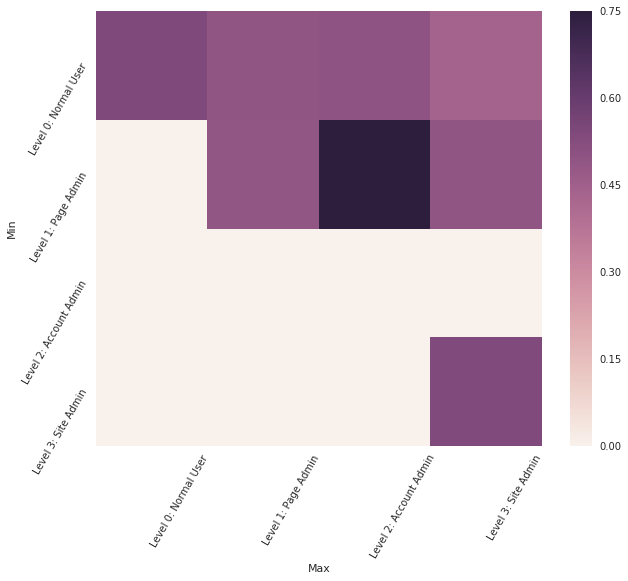

In [301]:
# discrepancy in status heatmap
data = []
total_d = []
values = [0, 1, 2, 3]
for v in values[::-1]:
    cur = []
    cur_d = []
    for v1 in values:
        cur.append(0)
        cur_d.append(0)
    data.append(cur)
    total_d.append(cur_d)
aspect = 'status'
for pair in feature_sets:
    f, clss = pair
    data[f['min_%s'%(aspect)]][f['max_%s'%(aspect)]] += (1-clss)
    total_d[f['min_%s'%(aspect)]][f['max_%s'%(aspect)]] += 1
for v in values[::-1]:
    for v1 in values:
        if total_d[v][v1]:
            data[v][v1] /= total_d[v][v1]
legends = ['Level 0: Normal User', 'Level 1: Page Admin', 'Level 2: Account Admin', 'Level 3: Site Admin']
plt.figure(figsize=(10, 8))
sns.heatmap(data)
plt.ylabel('Min')
plt.xlabel('Max')
plt.yticks([v + 0.5 for v in values], legends[::-1], rotation=60)
plt.xticks([v + 0.75 for v in values], legends, rotation=60)
plt.show()

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


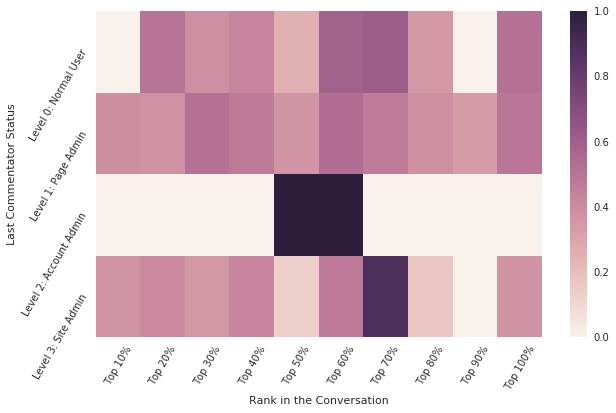

In [318]:
# propencity of attacking
data = []
total_d = []
values = [0, 1, 2, 3]
for v in values[::-1]:
    cur = []
    cur_d = []
    for v1 in range(10):
        cur.append(0)
        cur_d.append(0)
    data.append(cur)
    total_d.append(cur_d)
aspect = 'status'
for ind, pair in enumerate(documents):
    f, clss, conv_id = pair
    actions = f['action_feature']
    end_time = max([a['timestamp_in_sec'] for a in actions])
    for a in actions:
        if a['timestamp_in_sec'] == end_time:
            if 'user_text' in a and aspect in user_info[ind][a['user_text']]:
                last = user_info[ind][a['user_text']][aspect]
            else:
                last = None
                break
    if last== None or last == -1: continue
    vals = []
    for a in actions:
        if a['timestamp_in_sec'] < end_time and 'user_text' in a and aspect in user_info[ind][a['user_text']]:
            vals.append(user_info[ind][a['user_text']][aspect])
    rank = len([v for v in vals if v >= last])
   # print(last, int(rank/len(vals)*10)-1)
    data[last][int(rank/len(vals)*10)-1] += (1-clss)
    total_d[last][int(rank/len(vals)*10)-1] += 1
for v in values:
    for v1 in range(10):
        if total_d[v][v1]:
            data[v][v1] /= total_d[v][v1]
legends = ['Level 0: Normal User', 'Level 1: Page Admin', 'Level 2: Account Admin', 'Level 3: Site Admin']
plt.figure(figsize=(10, 6))
sns.heatmap(data)
plt.ylabel('Last Commentator Status')
plt.xlabel('Rank in the Conversation')
leg = []
for l in range(10):
    leg.append('Top %d%%'%((l+1)*10))
plt.yticks([v + 0.5 for v in values], legends[::-1], rotation=60)
plt.xticks([v + 0.5 for v in range(10)], leg, rotation=60)
plt.show()

In [319]:
def get_tile(num, tiles):
    for ind, t in enumerate(tiles):
        if num < t:
            return 10 - ind
    return 1

In [323]:
def discrepancy_heatmap(aspect, feature_sets):
    values = []
    for pair in feature_sets:
        f, clss = pair
        values.append(f['min_%s'%(aspect)])
        values.append(f['max_%s'%(aspect)])
    values = np.array(values)
    total_d = []
    data = []
    for v in range(10):
        cur = []
        cur_d = []
        for v1 in range(10):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    tiles = []
    for p in range(11):
        lower = np.percentile(values, p*10)
        tiles.append(lower)
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
        #print(mini,maxi, tiles)
        data[mini][maxi] += clss
        total_d[mini][maxi] += 1
    for v in range(10):
        for v1 in range(10):
            if total_d[v][v1]:
                data[v][v1] /= total_d[v][v1]
    legends = []
    for l in range(10):
        legends.append('Top %d%%'%((l+1)*10))
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[::-1])
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(10)], legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(10)], legends, rotation=60)
    plt.show()
    return tiles

In [332]:
# propencity of attacking
def propencity_of_attacking(aspect, user_infos, documents, tiles):
    data = []
    total_d = []
    for v in range(10):
        cur = []
        cur_d = []
        for v1 in range(10):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    for ind, pair in enumerate(documents):
        f, clss, conv_id = pair
        actions = f['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        
        for a in actions:
            if a['timestamp_in_sec'] == end_time:
                if 'user_text' in a and aspect in user_info[ind][a['user_text']]:
                    last = user_info[ind][a['user_text']][aspect]
                else:
                    last = None
                    break
        if last== None: continue
        global_rank = get_tile(last, tiles)
        vals = []
        for a in actions:
            if a['timestamp_in_sec'] < end_time and 'user_text' in a and aspect in user_info[ind][a['user_text']]:
                vals.append(user_info[ind][a['user_text']][aspect])
        rank = len([v for v in vals if v >= last])
        data[global_rank][int(rank/len(vals)*10)-1] += (1-clss)
        total_d[global_rank][int(rank/len(vals)*10)-1] += 1
    for v in range(10):
        for v1 in range(10):
            if total_d[v][v1]:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 6))
    sns.heatmap(data)
    plt.ylabel('Global Rank')
    plt.xlabel('Local Rank')
    leg = []
    for l in range(10):
        leg.append('Top %d%%'%((l+1)*10))
    plt.yticks([v + 0.5 for v in range(10)], leg[::-1], rotation=60)
    plt.xticks([v + 0.5 for v in range(10)], leg, rotation=60)
    plt.show()

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


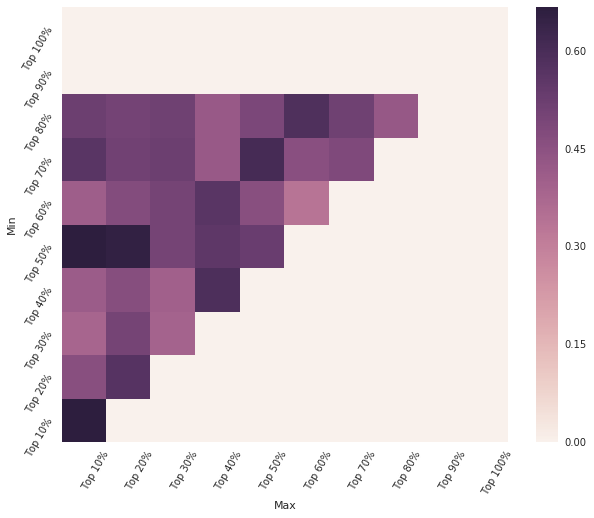

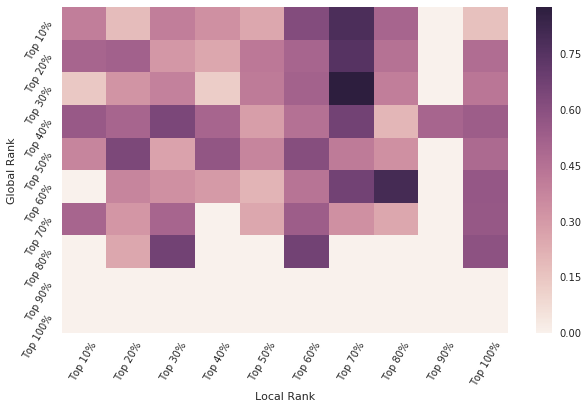

In [333]:
aspect = 'all_talk_page_experience'
tiles = discrepancy_heatmap(aspect, feature_sets)
propencity_of_attacking(aspect, user_infos, documents, tiles)

# Plots and Examples

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


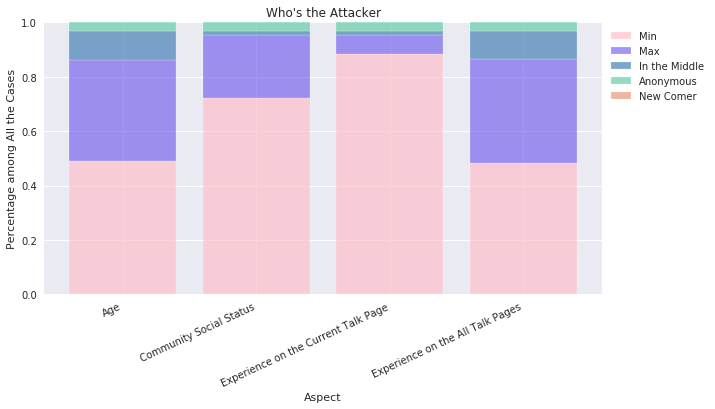

In [277]:
plot_profiles(profiles, 1)

In [21]:
get_examples(documents, feature_sets, 'last_3_LEXICON_pron_you', 1, 1)

 == More precise about Italian position on the Imia dispute ==
SilentResident
-1
 I have restored the previous sentence  as it is better to just quote the italian position, to minimize any possible room for misconceptions about the Italian government's position. Italy did not state that the protocol is just "valid" but "valid and continuous to be valid", meaning that it was not only valid at that moment, but continuously valid.
SilentResident
0
 : There is no advantage in doing so. "Being valid" and "continuing to be valid" mean exactly the same thing. The repetition is merely a means of rhetorical emphasis on the part of the Italian politician – which is fine in the context of political language, but devoid of any additional information value for an encyclopedia. The only effect of repeating this rhetorical figure here in our own language would be to give the statement extra loudness – which may seem attractive to you, because you evidently like to trumpet things out to the reader at 

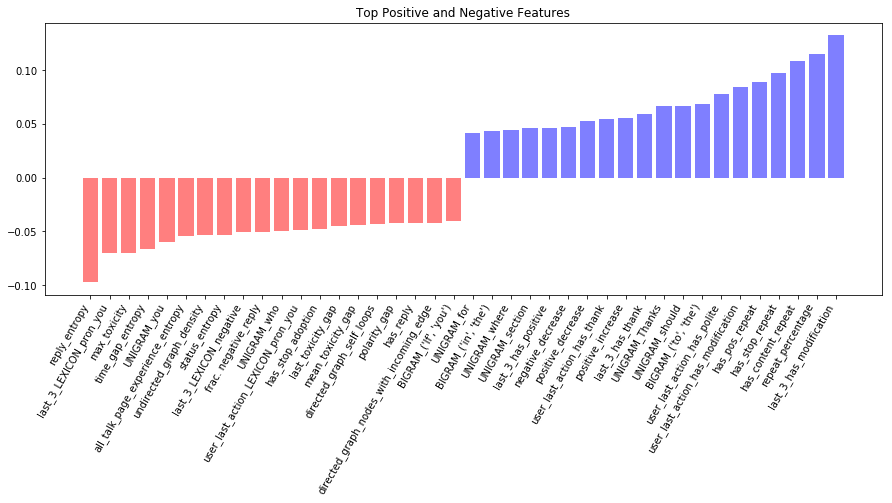

In [176]:
classifier = linear_model.LogisticRegression(C=0.003)
classifier.fit(X, y)
top_pos, top_neg= plot_coefficients(classifier, feature_names)
#0.630 (+/-0.007) for {'C': 0.0006}

finish collecting


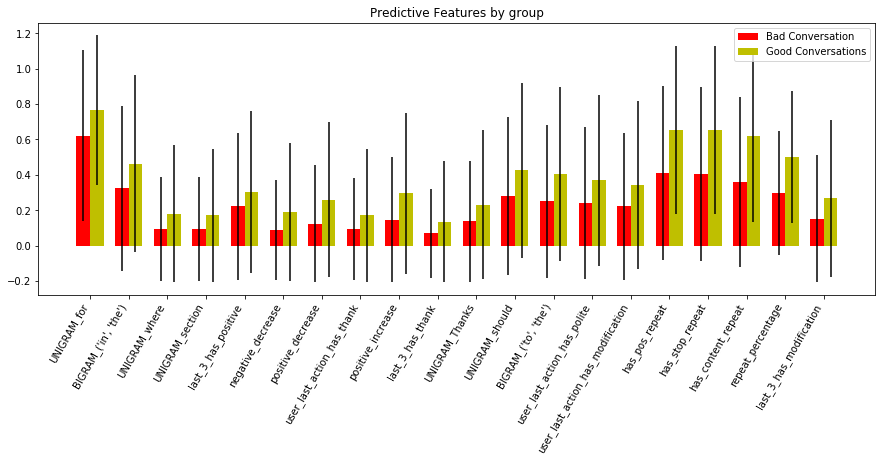

In [177]:
plot_feature_distribution(feature_sets, top_pos)

finish collecting


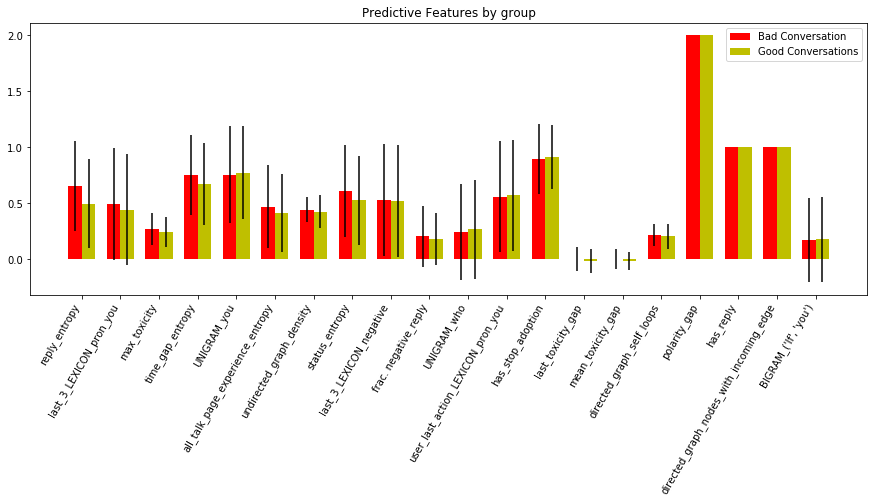

In [178]:
plot_feature_distribution(feature_sets, top_neg)

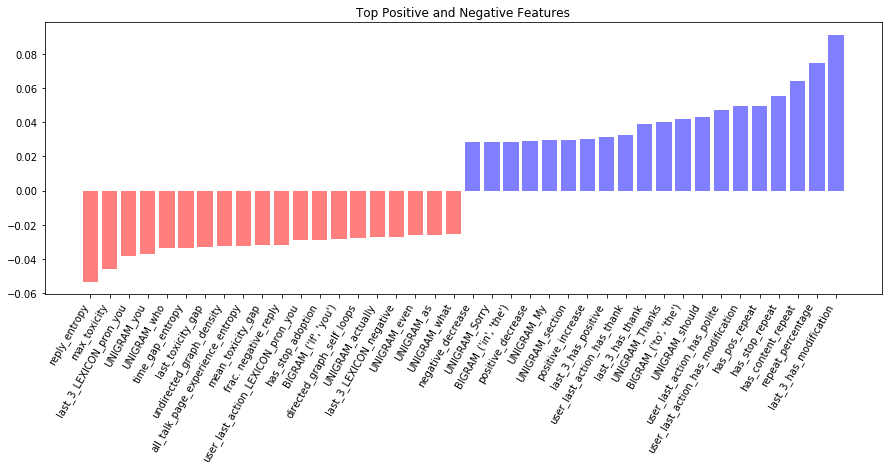

In [180]:
classifier = svm.LinearSVC(C=0.0006)
classifier.fit(X, y)
top_pos, top_neg = plot_coefficients(classifier, feature_names)
# bow + action(last 3 actions) + repeat + entropy
# 0.655 (+/-0.007) for {'C': 0.0006}

In [ ]:
# Output Feature Names

In [148]:
negative_features = {c:[] for c in constraints}
positive_features = {c:[] for c in constraints}

In [206]:
negative_features[constraint].append(yy)
positive_features[constraint].append(xx)

In [209]:
for n in negative_features.keys():
    negative_features[n] = negative_features[n][0]

In [210]:
for n in positive_features.keys():
    positive_features[n] = positive_features[n][0]

In [211]:
pd.DataFrame.from_dict(negative_features).to_csv('feature_results_negative.csv', index=False)

In [212]:
pd.DataFrame.from_dict(positive_features).to_csv('feature_results_positive.csv', index=False)

# Spearman Correlation

In [874]:
corr = []
pval = []
names = []
for key in features_corr:
    x,p = spearmanr(number_users, features_corr[key])
    corr.append(x)
    pval.append(p)
    names.append(key)


N = len(corr)

ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

#plt.subplots()
plt.figure(figsize=(15, 5))
plt.bar(ind, corr, width, color='green', alpha=0.5, yerr=pval)

# add some text for labels, title and axes ticks
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation between graph features and number of users')
plt.xticks(ind, names, rotation=60, ha='right')
#ax.set_xticklabels(names)

plt.show()